In [1]:

from os.path import exists
import random
import os
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
import scipy.sparse as scpy
from torch.nn import Linear
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.data as data
import torch_geometric.data.data as Batch
import torch.utils.data as data_utils
import torch_geometric.transforms as T
from torch.nn.init import xavier_uniform
from sklearn.metrics import roc_curve, auc
import torch_geometric.datasets as datasets
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch_geometric.transforms as transforms
from sklearn.preprocessing import label_binarize
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset, Data
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torch_geometric.nn import  GATv2Conv, GraphNorm,  SAGEConv, global_mean_pool, global_max_pool


## Función para crear splits


- Argumentos
    - path: Ruta a la carpeta con los archivos preprocesados de los grafos
    - split: Proporcion empleada para realizar el split train/test
    - seed: Semilla de aleatoriedad empleada en el particionamiento
    - parcela: Indice desde el que empezar a enumerar las particiones

- Return
    - Lista que contiene los grafos de test en la primera posición y los grafos de entrenamiento en la segunda posición.



In [5]:
def split_sp(path,seed=1,split=0.9,parcela=0):
    np.random.seed(seed)
    random.seed(seed)
    parcelas = os.listdir(path)
    n_sample = round(len(parcelas)*split)
    train_ind = np.random.choice(np.linspace(1,len(parcelas),len(parcelas)),n_sample,replace=False).astype(int)
    test_ind = np.delete(np.linspace(1,len(parcelas),len(parcelas)),train_ind-1).astype(int)
    test_graphs = []
    train_graphs = []
    
    parcela = parcela 
    for itrain in train_ind:
        filename = f"{path}/parcela{itrain}"
        archivos = os.listdir(filename)
        ngrafos=int(len(archivos)/4)
        parcela+=1
        for i in range(ngrafos):
            i+=1
            edges = pd.read_csv(f"{filename}/el{i}.csv").iloc[:,1:]
            attributes = pd.read_csv(f"{filename}/z{i}.csv").iloc[:,1]
            label = pd.read_csv(f"{filename}/y{i}.csv").iloc[:,1]
            weights = pd.read_csv(f"{filename}/ea{i}.csv").iloc[:,1]
            weights = torch.tensor(weights.to_numpy(),dtype=torch.float)
            edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
            edge_idx -= 1
            attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
            np_lab = label.to_numpy()
            y = torch.tensor(np_lab, dtype=torch.long)-1
            y = y[0]
            graph = Data(x=attrs, edge_index=edge_idx,  y=y, edge_attr = weights,parcela=parcela)
            train_graphs.append(graph)     
    for itest in test_ind:
        filename = f"{path}/parcela{itest}"
        archivos = os.listdir(filename)
        ngrafos=int(len(archivos)/4)
        parcela+=1
        for i in range(ngrafos):
            i+=1
            edges = pd.read_csv(f"{filename}/el{i}.csv").iloc[:,1:]
            attributes = pd.read_csv(f"{filename}/z{i}.csv").iloc[:,1]
            label = pd.read_csv(f"{filename}/y{i}.csv").iloc[:,1]
            weights = pd.read_csv(f"{filename}/ea{i}.csv").iloc[:,1]
            weights = torch.tensor(weights.to_numpy(),dtype=torch.float)
            edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
            edge_idx -= 1
            attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
            np_lab = label.to_numpy()
            y = torch.tensor(np_lab, dtype=torch.long)-1
            y = y[0]
            graph = Data(x=attrs, edge_index=edge_idx,  y=y, edge_attr = weights,parcela=parcela)
            test_graphs.append(graph)
    return [test_graphs,train_graphs]
            

## Leer y particionar de forma estratificada los grafos de cada especie

El valor de **parcela** se actualiza entre especies, sirve como contador para identificar posteriormente a que segmento pertenece cada grafo.

En la carpeta **datos2** están los grafos sin suelo.
En la carpeta **datos** están los grafos completos.

In [6]:
datos1 = split_sp(path='./datos2/grafos/train/sp1',parcela=0)
parcela=(len(datos1[0])+len(datos1[1]))
datos2 = split_sp(path='./datos2/grafos/train/sp2',parcela=parcela)
parcela=parcela+(len(datos2[0])+len(datos2[1]))
datos3 = split_sp(path='./datos2/grafos/train/sp3',parcela=parcela)

Separar los grafos de entrenamiento y test en dos listas y almacenarlas en un archivo .pkl para poder cargarlas en memoria mas rapidamente. 

In [7]:
test = []
test.extend(datos1[0])
test.extend(datos2[0])
test.extend(datos3[0])

train = []
train.extend(datos1[1])
train.extend(datos2[1])
train.extend(datos3[1])

with open("./datos2/train_graphs1_90.pkl",'wb') as f:
    pickle.dump(train,f)
with open("./datos2/test_graphs1_90.pkl",'wb') as f:
    pickle.dump(test,f)

## Clase Dataset 

Lee los archivos .pkl almacenando en memoria los grafos para entrenamiento y test

In [2]:
class GraphDataset(InMemoryDataset):
    def __init__(self, path):
        self.path = path
        self.data_list = []
        with open(path,'rb') as f:
            self.data_list.extend(pickle.load(f))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


In [3]:
train_dataset = GraphDataset("./datos/train_graphs1_90.pkl")
test_dataset = GraphDataset("./datos/test_graphs1_90.pkl")

In [4]:
print(train_dataset)
print(test_dataset)

GraphDataset(49182)
GraphDataset(6327)


# Modelo de clasificación

- Graph attention network 16 cabezas
    - input = $N \times 1$
    - output = $N \times (4 \times 16)$
- Graph norm (normalización de las features a nivel grafo)
    - input = $N \times 64$
    - output = $N \times 64$
- Graph sage
    - input = $N \times 64$
    - output = $N \times 64$
- Max pooling
    - input $N \times 64$
    - output $1 \times 64$
- Mean pooling
    - input $N \times 64$
    - output $1 \times 64$
- Concatenación  
    - input $(1 \times 64, 1 \times 64)$
    - output $1 \times 128$
- Fully connected 1
    - input $1 \times 128$
    - output $1 \times 2048$
- Fully connected 2
    - input $1 \times 2048$
    - output $1 \times 1024$
- Fully connected 3
    - input $1 \times 1024$
    - output $1 \times 3$

In [5]:
# funcion para inicializar pesos de la red
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
        
dp=0.2


class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 64
        self.in_head = 16
        self.out_head = 2
        self.conv1 =  GATv2Conv(1, 4,edge_dim=1,heads=self.in_head,concat=True)
        self.conv2 =  SAGEConv(4*self.in_head, self.hid,normalize=False)
        self.norm1=GraphNorm(4*self.in_head)
        self.fc1 = nn.Linear(self.hid*2,2048)
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024,3)
        self.conv1.apply(init_weights)
        self.conv2.apply(init_weights)
        self.fc1.apply(init_weights)
        self.fc2.apply(init_weights)
        self.fc3.apply(init_weights)


    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        edge_attr = torch.unsqueeze(edge_attr,1)
        x = torch.unsqueeze(x,-1)
        
        x = self.conv1(x,edge_index,edge_attr)
        x = F.relu(x)
        x = self.norm1(x,batch)
        x = F.dropout(x, p=dp, training=self.training)
        
        x = self.conv2(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dp, training=self.training)
        
        x1 = global_max_pool(x,batch)
        x2 = global_mean_pool(x,batch)
        x = torch.cat((x1,x2),1)
        
        x = self.fc1(x)
        x = F.dropout(x, p=dp, training=self.training)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.dropout(x, p=dp, training=self.training)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x



Chekear si hay tarjeta grafica disponible  
Inicializar modelo  
Inicializar optimizador  

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT().to(device)

wd=5e-4
lr=0.000005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)




Bucle de entrenamiento

In [9]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

data_test=DataLoader(test_dataset,batch_size=250,shuffle=True,drop_last=True)

for i , batch in enumerate(data_test):
    dat = batch.to(device)
    batch = data.Batch(batch)

tbn=0
optimizer.zero_grad()
l=torch.nn.CrossEntropyLoss(torch.tensor([1.1,1.05,1.0]).to(device))

for epoch in range(400):
    model.train()
    lss=0

    lr=0.0001
    dp=0.1 #0.15


    wd=0.00005
    train=DataLoader(train_dataset,batch_size=80,shuffle=True,drop_last=True)
    count=0
    for idx, batch in enumerate(train):
        batch=batch.to(device)
        out = model(batch)
        loss = l(out, batch.y)
        lss+=loss.item()
        loss.backward()
        if(idx!=0 and idx%5==0):
            torch.nn.utils.clip_grad_norm_(model.parameters(),2)
            optimizer.step()
            optimizer.zero_grad()
        count+=1


    tbn+=1
    lss=lss/count
    writer.add_scalar('Training/Loss', float(lss), tbn)
    print('[Epoch %4d/%4d] Loss: % 2.2e' % (epoch + 1, 250, lss))
    model.eval()
    loss2=0
    count2=0
    for i, batch in enumerate(data_test):
        count2+=1
        dat = batch.to(device)
        with torch.no_grad():
            pred=model(dat)
            loss2 += l(pred, dat.y)
    loss2 = loss2/count2
    writer.add_scalar('test/Loss', float(loss2), tbn)
    print('[Epoch %4d/%4d] Test Loss: % 2.2e' % (epoch + 1, 250, loss2))
    if(loss2<0.6):
        break

writer.flush()
writer.close()

[Epoch    1/ 250] Loss:  1.07e+00
[Epoch    1/ 250] Test Loss:  1.06e+00
[Epoch    2/ 250] Loss:  1.04e+00
[Epoch    2/ 250] Test Loss:  1.03e+00
[Epoch    3/ 250] Loss:  1.02e+00
[Epoch    3/ 250] Test Loss:  1.01e+00
[Epoch    4/ 250] Loss:  1.00e+00
[Epoch    4/ 250] Test Loss:  9.86e-01
[Epoch    5/ 250] Loss:  9.84e-01
[Epoch    5/ 250] Test Loss:  9.74e-01
[Epoch    6/ 250] Loss:  9.71e-01
[Epoch    6/ 250] Test Loss:  9.60e-01
[Epoch    7/ 250] Loss:  9.60e-01
[Epoch    7/ 250] Test Loss:  9.46e-01
[Epoch    8/ 250] Loss:  9.51e-01
[Epoch    8/ 250] Test Loss:  9.35e-01
[Epoch    9/ 250] Loss:  9.43e-01
[Epoch    9/ 250] Test Loss:  9.26e-01
[Epoch   10/ 250] Loss:  9.33e-01
[Epoch   10/ 250] Test Loss:  9.20e-01
[Epoch   11/ 250] Loss:  9.25e-01
[Epoch   11/ 250] Test Loss:  9.07e-01
[Epoch   12/ 250] Loss:  9.21e-01
[Epoch   12/ 250] Test Loss:  9.03e-01
[Epoch   13/ 250] Loss:  9.15e-01
[Epoch   13/ 250] Test Loss:  8.97e-01
[Epoch   14/ 250] Loss:  9.11e-01
[Epoch   14/ 250]

[Epoch  113/ 250] Test Loss:  7.96e-01
[Epoch  114/ 250] Loss:  7.79e-01
[Epoch  114/ 250] Test Loss:  8.01e-01
[Epoch  115/ 250] Loss:  7.80e-01
[Epoch  115/ 250] Test Loss:  7.98e-01
[Epoch  116/ 250] Loss:  7.80e-01
[Epoch  116/ 250] Test Loss:  7.89e-01
[Epoch  117/ 250] Loss:  7.81e-01
[Epoch  117/ 250] Test Loss:  7.83e-01
[Epoch  118/ 250] Loss:  7.78e-01
[Epoch  118/ 250] Test Loss:  7.92e-01
[Epoch  119/ 250] Loss:  7.77e-01
[Epoch  119/ 250] Test Loss:  7.90e-01
[Epoch  120/ 250] Loss:  7.78e-01
[Epoch  120/ 250] Test Loss:  7.96e-01
[Epoch  121/ 250] Loss:  7.78e-01
[Epoch  121/ 250] Test Loss:  7.85e-01
[Epoch  122/ 250] Loss:  7.77e-01
[Epoch  122/ 250] Test Loss:  7.84e-01
[Epoch  123/ 250] Loss:  7.74e-01
[Epoch  123/ 250] Test Loss:  7.84e-01
[Epoch  124/ 250] Loss:  7.76e-01
[Epoch  124/ 250] Test Loss:  7.91e-01
[Epoch  125/ 250] Loss:  7.77e-01
[Epoch  125/ 250] Test Loss:  7.84e-01
[Epoch  126/ 250] Loss:  7.78e-01
[Epoch  126/ 250] Test Loss:  8.00e-01
[Epoch  127/

KeyboardInterrupt: 

## Evaluación de la clasificación punto a punto

In [8]:
n_test = len(test_dataset)
l=torch.nn.CrossEntropyLoss(torch.tensor([1.1,1.05,1.0]).to(device))
data_test=DataLoader(test_dataset,batch_size=n_test,shuffle=True,drop_last=True)
for i , batcht in enumerate(data_test):
    dat = batcht.to(device)

print('Specie 1: ',sum(dat.y==0))
print('Specie 2: ',sum(dat.y==1))
print('Specie 3: ',sum(dat.y==2))
with torch.no_grad():
    model.eval()
    pred = model(dat)
    prob = torch.softmax(pred,dim=1)
    _, predicted = torch.max(pred, 1)
    print('Loss: ',l(pred,dat.y).item())
    print('Accuracy: ',metrics.accuracy_score(dat.y.to('cpu'),predicted.to('cpu')))
    print('Balanced Accuracy: ',metrics.balanced_accuracy_score(dat.y.to('cpu'),predicted.to('cpu')))
    print(metrics.confusion_matrix(dat.y.to('cpu'),predicted.to('cpu')))
    print('roc_auc:',metrics.roc_auc_score(dat.y.to('cpu'),prob.to('cpu'),multi_class='ovo'))
    print('macro recall: ', metrics.recall_score(dat.y.to('cpu'), predicted.to('cpu'), labels=[0,1,2], average='macro'))
    print('micro recall: ', metrics.recall_score(dat.y.to('cpu'), predicted.to('cpu'), labels=[0,1,2], average='micro'))
    print('macro f1: ', metrics.f1_score(dat.y.to('cpu'), predicted.to('cpu'), labels=[0,1,2], average='macro'))
    print('micro f1: ', metrics.f1_score(dat.y.to('cpu'), predicted.to('cpu'), labels=[0,1,2], average='micro'))

Specie 1:  tensor(1758, device='cuda:0')
Specie 2:  tensor(1757, device='cuda:0')
Specie 3:  tensor(2812, device='cuda:0')
Loss:  0.752187192440033
Accuracy:  0.6707760391970918
Balanced Accuracy:  0.6594772117650963
[[1155  265  338]
 [ 221 1044  492]
 [ 406  361 2045]]
roc_auc: 0.8397900470395472
macro recall:  0.6594772117650963
micro recall:  0.6707760391970918
macro f1:  0.6603352433231245
micro f1:  0.6707760391970918


## Curvas ROC

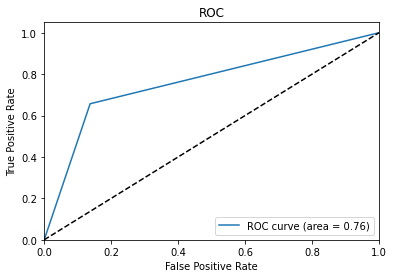

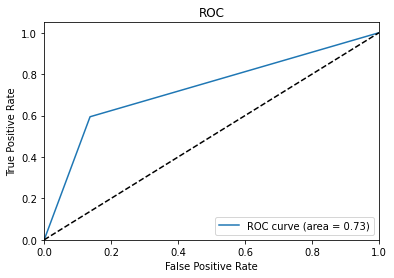

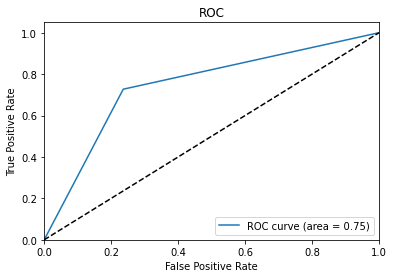

In [9]:
labels=label_binarize(dat.y.to('cpu'),classes=[0,1,2])
predictions=label_binarize(predicted.to('cpu'),classes=[0,1,2])

n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

## Evaluación de la clasificación a nivel segmento

In [38]:
n_test = len(test_dataset)

l=torch.nn.CrossEntropyLoss(torch.tensor([1.1,1.05,1.0]).to(device))
data_test=DataLoader(test_dataset,batch_size=n_test,shuffle=True,drop_last=True)
for i , batcht in enumerate(data_test):
    dat = batcht.to(device)


pred_grid = []
true_grid = []
def unique(list_1):
    unique_list = []
    for n in list_1:
        if n not in unique_list:
            unique_list.append(n)
    return unique_list

parcelas = unique(dat.parcela)

with torch.no_grad():
    datos = dat
    labels = dat.y
    model.eval()
    pred = model(datos)
    prob = torch.softmax(pred,dim=1)
    sz = pred.size()
    prob = pred.reshape(sz[1],sz[0])
    prob = torch.softmax(pred,1)
    acc = []
    for i in parcelas:
        i+=1
        ind=(dat.parcela==i)
        if(sum(ind)>0):
            sum_prob=torch.sum(prob[ind,],-2,keepdim=True)
            proba = torch.softmax(sum_prob,dim=1)
            _, predicted = torch.max(proba, 1)
            pred_grid.append(predicted)
            true_grid.append(labels[ind][0])


In [41]:
p = []
t = []

for i in pred_grid:
    p.append(i.to('cpu').item())
    
for i in true_grid:
    t.append(i.to('cpu').item())  
    
    
print('Accuracy: ',metrics.accuracy_score(p,t))
print('Balanced Accuracy: ',metrics.balanced_accuracy_score(p,t))
print(metrics.confusion_matrix(p,t))
print('macro recall: ', metrics.recall_score(p, t, labels=[0,1,2], average='macro'))
print('micro recall: ', metrics.recall_score(p,t, labels=[0,1,2], average='micro'))
print('macro f1: ', metrics.f1_score(p, t, labels=[0,1,2], average='macro'))
print('micro f1: ', metrics.f1_score(p, t, labels=[0,1,2], average='micro'))


Accuracy:  0.8235294117647058
Balanced Accuracy:  0.860576923076923
[[13  2  1]
 [ 0  9  0]
 [ 2  4 20]]
macro recall:  0.860576923076923
micro recall:  0.8235294117647058
macro f1:  0.8132578357355295
micro f1:  0.8235294117647058


In [ ]:
# error a nivel segmento en las particiones obtenidas con las semillas 1,2,3,4 y 5

# con suelo
# split 1: 0.8832
# split 2: 0.8465
# split 3: 0.7712
# split 4: 0.8029
# split 5: 0.8156

print('Error con suelo: ',(0.8832+0.8465+0.7712+0.8029+0.8156)/5)
# sin suelo
# split 1: 0.8751
# split 2: 0.7656
# split 3: 0.9070
# split 4: 0.8471
# split 5: 0.8127
print('Error sin suelo: ',(0.8751+0.7656+0.9070+0.8471+0.8127)/5)

Guardar o cargar modelos ya entrenados

In [96]:

    
#torch.save(model.state_dict(),'./modelo_seed2_90')



In [7]:
#model.load_state_dict(torch.load('./modelo_seed1_90'))
#model.eval()

GAT(
  (conv1): GATv2Conv(1, 4, heads=16)
  (conv2): SAGEConv(64, 64)
  (norm1): GraphNorm(64)
  (fc1): Linear(in_features=128, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=3, bias=True)
)